In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import json
from datetime import datetime

In [ ]:
# Load data and initialize DataFrame
with open('test_answer.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data['rows'], columns=data['columns'])
df['evaluation'] = 'Not Evaluated'
df['comment'] = ''
df['candidate_name'] = ''
df['position'] = ''
df['role_level'] = ''
df['timestamp'] = ''

In [10]:
data.keys()

dict_keys(['ok', 'database', 'query_name', 'rows', 'truncated', 'columns', 'query', 'error', 'private', 'allow_execute_sql', 'query_ms'])

In [20]:
data['rows'][0]

['dc384399-cb1c-452c-81b6-ef211e112664',
 'openai-gpt',
 "\n\n    Extract the information from the PDF file, this is the information of the candidate. Write an email specific to the candidate skills offering a position in our company.\n    The email should be professional and concise, highlighting the skills and experience that match the job description by addressing the role that the candidate will play in the company specific to their profile.\n    Fill out all the candidate information in the email.\n    The position of the role will be decided based on the candidate's skills and experience, and the level of the job will be specify based on the experience either Junio, Mid or Senior.\n    Highlight skills, requirements, nice to have and responsabilities on the role that match with the canidates abilities\n\n    CONTEXT: who is this?\n    QUESTION: [Page 1]: Contactar sotoblanco263542@gmail.com www.linkedin.com/in/pastor- soto-34215b125 (LinkedIn) www.upwork.com/freelancers/ ~01f0e01

In [ ]:
class EmailReviewInterface:
    def __init__(self):
        self.current_index = 0
        self.total_emails = len(df)
        
        # Create widgets
        self.progress_text = widgets.HTML()
        self.status_text = widgets.HTML()
        self.model_text = widgets.HTML()
        
        # New fields for candidate info
        self.name_input = widgets.Text(
            description='Name:',
            layout=widgets.Layout(width='300px')
        )
        
        self.position_dropdown = widgets.Dropdown(
            options=['', 'MLE', 'Data Engineer', 'Data Scientist', 'AI Engineer', 'Software Engineer'],
            description='Position:',
            layout=widgets.Layout(width='300px')
        )
        
        self.role_level_dropdown = widgets.Dropdown(
            options=['', 'Junior', 'Mid', 'Senior', 'Principal', 'Lead'],
            description='Level:',
            layout=widgets.Layout(width='300px')
        )
        
        self.input_area = widgets.Textarea(
            description='Input:',
            disabled=True,
            layout=widgets.Layout(width='95%', height='150px')
        )
        
        self.output_area = widgets.Textarea(
            description='Output:',
            disabled=True,
            layout=widgets.Layout(width='95%', height='150px')
        )
        
        self.evaluation_dropdown = widgets.Dropdown(
            options=['Not Evaluated', 'Good', 'Bad'],
            description='Rating:',
            layout=widgets.Layout(width='200px')
        )
        
        self.comment_area = widgets.Textarea(
            placeholder='Please explain your rating...',
            description='Comment:',
            layout=widgets.Layout(width='95%', height='100px')
        )
        
        self.save_button = widgets.Button(
            description='Save All',
            button_style='success',
            layout=widgets.Layout(width='150px')
        )
        
        self.next_button = widgets.Button(
            description='Next →',
            button_style='primary',
            disabled=True
        )
        
        self.prev_button = widgets.Button(
            description='← Previous',
            button_style='primary',
            disabled=True
        )
        
        self.export_button = widgets.Button(
            description='Export to CSV',
            button_style='success',
            layout=widgets.Layout(width='150px')
        )
        
        # Set up callbacks
        self.next_button.on_click(self.next_email)
        self.prev_button.on_click(self.prev_email)
        self.export_button.on_click(self.export_to_csv)
        self.evaluation_dropdown.observe(self.on_evaluation_change, names='value')
        self.save_button.on_click(self.save_all)
        
        # Initial display
        self.update_display()
    
    def update_display(self):
        clear_output(wait=True)
        
        # Update progress and buttons
        progress = f"Email {self.current_index + 1} of {self.total_emails}"
        self.progress_text.value = f"<h3>{progress}</h3>"
        
        row = df.iloc[self.current_index]
        self.model_text.value = f"<b>Model:</b> {row['model']}<br><br>"
        
        # Update content
        self.input_area.value = row['prompt']
        self.output_area.value = row['response']
        self.evaluation_dropdown.value = row['evaluation']
        self.comment_area.value = row['comment']
        self.name_input.value = row['candidate_name']
        self.position_dropdown.value = row['position']
        self.role_level_dropdown.value = row['role_level']
        
        # Update button states
        self.prev_button.disabled = self.current_index == 0
        self.next_button.disabled = (self.current_index == self.total_emails - 1) or \
                                   (self.evaluation_dropdown.value == 'Not Evaluated') or \
                                   (not df.at[self.current_index, 'comment'].strip())
        
        # Display all elements
        display(self.progress_text)
        display(self.model_text)
        display(widgets.HBox([self.name_input]))
        display(widgets.HBox([self.position_dropdown, self.role_level_dropdown]))
        display(widgets.HTML("<br>"))
        display(self.input_area)
        display(self.output_area)
        display(widgets.HBox([self.evaluation_dropdown]))
        display(self.comment_area)
        display(widgets.HBox([self.save_button]))
        display(widgets.HBox([self.prev_button, self.next_button]))
        display(self.export_button)
        
        # Show completion status
        evaluated = (df['evaluation'] != 'Not Evaluated').sum()
        self.status_text.value = f"<br>Progress: {evaluated}/{self.total_emails} emails evaluated"
        display(self.status_text)
    
    def next_email(self, b):
        if self.current_index < self.total_emails - 1:
            self.current_index += 1
            self.update_display()
    
    def prev_email(self, b):
        if self.current_index > 0:
            self.current_index -= 1
            self.update_display()
    
    def on_evaluation_change(self, change):
        df.at[self.current_index, 'evaluation'] = change['new']
        self.update_display()
    
    def save_all(self, b):
        df.at[self.current_index, 'comment'] = self.comment_area.value
        df.at[self.current_index, 'candidate_name'] = self.name_input.value
        df.at[self.current_index, 'position'] = self.position_dropdown.value
        df.at[self.current_index, 'role_level'] = self.role_level_dropdown.value
        self.update_display()
    
    def export_to_csv(self, b):
        # Update timestamp for current evaluation
        df.at[self.current_index, 'timestamp'] = datetime.now().isoformat()
        
        # Save to CSV with proper escaping
        df.to_csv('email_evaluations.csv', 
                 index=False, 
                 quoting=1,  # Quote all fields
                 escapechar='\')
        
        self.status_text.value = f"<br><b>✓ Exported to email_evaluations.csv</b><br>" + self.status_text.value
        self.update_display()

In [30]:
# Initialize the interface
review_interface = EmailReviewInterface()

HTML(value='<h3>Email 20 of 20</h3>')

HTML(value='<b>Model:</b> openai-gpt<br><br>')

Textarea(value="\n\n    Extract the information from the PDF file, this is the information of the candidate. W…

Textarea(value='Subject: Exciting Data Engineering Opportunity Aligned with Your Expertise\n\nDear Mr. Reis,\n…

Textarea(value="job role wasn't display at the begining", description='Comment:', layout=Layout(height='100px'…

Button(button_style='success', description='Export to CSV', layout=Layout(width='150px'), style=ButtonStyle())

HTML(value='<br>Progress: 20/20 emails evaluated')

In [5]:
import pandas as pd
evals = pd.read_csv('email_evaluations.csv')

/tmp/ipykernel_3827/237969098.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Evaluation')


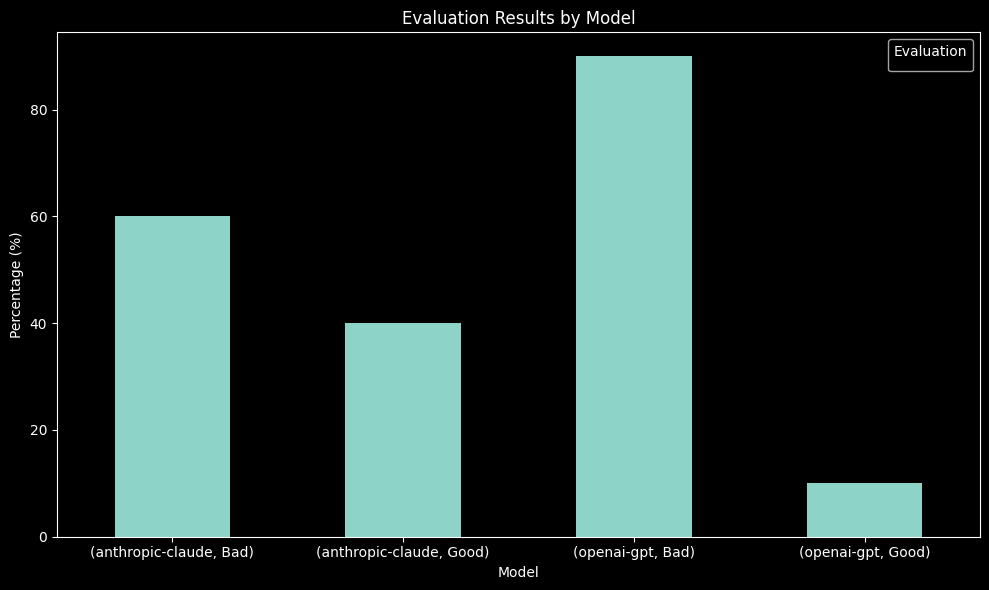

In [6]:
import matplotlib.pyplot as plt
# Group by model and evaluation, then count occurrences and express as percentage
evaluation_summary = evals.groupby(['model', 'evaluation']).size().unstack(fill_value=0)
evaluation_summary = evaluation_summary.div(evaluation_summary.sum(axis=1), axis=0) * 100
# Reset the index to make 'model' a column
evaluation_summary.reset_index(inplace=True)
# Set the model as the index for better plotting
evaluation_summary.set_index('model', inplace=True)
# Transpose the DataFrame for better plotting
evaluation_summary = evaluation_summary.transpose()
# Set the color palette
colors = ['#FF9999', '#66B3FF', '#99FF99']
# Create the bar plot
plt.figure(figsize=(10, 6))
evaluation_summary.unstack().plot(kind='bar')
plt.title('Evaluation Results by Model')
plt.xlabel('Model')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Evaluation')
plt.tight_layout()
plt.show()